In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-23T19:27:54.802367+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import time
notebookstart= time.time()

In [4]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [6]:
%watermark --iversions

seaborn   : 0.11.1
pandas    : 0.25.3
sklearn   : 0.24.2
matplotlib: 3.3.4
numpy     : 1.20.3



## Блок для воспроизводимости решений

In [7]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED  = 309487
XGB_RANDOMSEED = 56
LGB_RANDOMSEED = 874256

In [8]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [9]:
NTRY = 32
NAME = f'{NTRY}_cb_pca64_sber_bord_nose_iter_2mod'

In [10]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Загружаем данные

In [11]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [12]:
df_train.shape, df_test.shape, 

((6981, 570), (3000, 568))

Формируем списки числовых и категориальных переменных.   
Полностью категориальные и полностью числовых формируются автоматически.   

In [13]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr', 'interview']
['hour', 'dow', 'day', 'mounth', 'hour_peak', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


Остается распределить признаки, которые могу быть как категориальными, так и числовыми.    
Сделаем это.

In [14]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', #'distrib_brdr',
                 #'spec_event_1',
                ])

In [15]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    df_test[el] = df_test[el].astype(str)

Создаем Catboost Pools для обучения с условием разделения на start (данные до 2022-04-08) / end (данные после 2022-04-08)

In [16]:
#views
train_views_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['views']],
                         cat_features = cat_cols,
                        )
train_views_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['views']],
                       cat_features = cat_cols,
                      )
#depth
train_depth_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                         df_train[df_train.distrib_brdr == 1][['depth']],
                         cat_features = cat_cols,
                        )
train_depth_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 0][['depth']],
                       cat_features = cat_cols,
                      )

#frp
train_frp_start = Pool(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols],
                       df_train[df_train.distrib_brdr == 1][['full_reads_percent']],
                       cat_features = cat_cols,
                      )
train_frp_end = Pool(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols],
                     df_train[df_train.distrib_brdr == 0][['full_reads_percent']],
                     cat_features = cat_cols,

                    )

In [17]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [18]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

Обучаем модели для views с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [19]:
cb_params_views = {"iterations": 2500,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

Рассчитываем на cv оптимальное количество итераций по средней R2 на валидационных фолдах 

In [20]:
def get_model(inp_pool, inp_params):
    
    
    scores = cv(inp_pool,
                      inp_params,
                      fold_count=5,
                      seed = CB_RANDOMSEED, 
                      #plot="True"
                     )
    
    # проверка что лучшие итерации по test-RMSE-mean и test-R2-mean одинаковы
    # для cb чаще правда, для lgb и xgb чаще ложь
    #if scores['test-RMSE-mean'].argmin() != scores['test-R2-mean'].argmax():
    #    raise ValueError('wtf?', scores['test-RMSE-mean'].argmin(), scores['test-R2-mean'].argmax())
    
    print(scores[scores['test-R2-mean'] == scores['test-R2-mean'].max()].to_string())
    
    # из cv берем лучшее по test-R2-mean количество итераций
    # на нем и обучаем моедль на всех данных
    niters = scores['test-R2-mean'].argmax()
    print(niters)
    
    cb_model = CatBoostRegressor(iterations = niters,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                )
    # Fit model
    cb_model.fit(inp_pool,
                 #plot = True,
                 verbose = 100,
                )
    
    
    return cb_model

In [21]:
cb_params_views['iterations'] = 2500

In [22]:
%%time
model_views_start = get_model(train_views_start, cb_params_views)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2375        2375      0.504413     0.086275       0.996586      0.000576    57972.956437   21988.715914      4854.551041      182.243104
2375
Learning rate set to 0.024845
0:	learn: 83273.2632038	total: 62.5ms	remaining: 2m 28s
100:	learn: 54142.1735398	total: 5.82s	remaining: 2m 10s
200:	learn: 44865.9788177	total: 11.7s	remaining: 2m 6s
300:	learn: 39365.0900869	total: 17.3s	remaining: 1m 59s
400:	learn: 35126.7827694	total: 23.1s	remaining: 1m 53s
500:	learn: 31220.9663136	total: 28.7s	remaining: 1m 47s
600:	learn: 28056.7808811	total: 34.6s	remaining: 1m 42s
700:	learn: 25574.9410193	total: 39.8s	remaining: 1m 35s
800:	learn: 23464.1397191	total: 46.2s	remaining: 1m 30s
900:	learn: 21566.7536879	total: 52s	remaining: 1m 24s
1000:	learn: 19983.0904730	total: 57.8s	remaining: 1m 19s
1100:	learn: 18672.3072207	total: 1m 3s	remaining: 1m 13s
1200:	lea

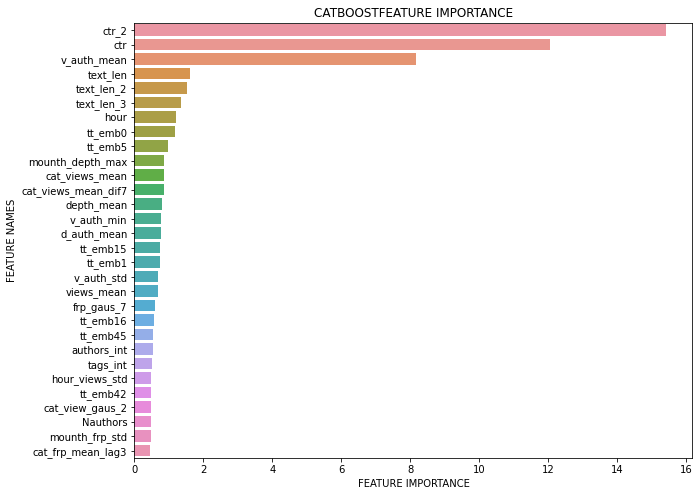

In [23]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_views_start.get_feature_importance(), train_views_start.get_feature_names(), 'CATBOOST')

In [24]:
cb_params_views['iterations'] = 750

In [25]:
%%time
model_views_end = get_model(train_views_end, cb_params_views)

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
744         744      0.572745      0.05119       0.908535      0.010343     9616.439571      882.14483      4485.661689      188.064859
744
Learning rate set to 0.061988
0:	learn: 14512.9835251	total: 74.6ms	remaining: 55.4s
100:	learn: 7737.8842613	total: 7.1s	remaining: 45.2s
200:	learn: 6261.6042873	total: 13.9s	remaining: 37.6s
300:	learn: 5298.7015610	total: 20.6s	remaining: 30.4s
400:	learn: 4572.8141940	total: 27.4s	remaining: 23.4s
500:	learn: 4020.7387642	total: 33.8s	remaining: 16.4s
600:	learn: 3542.6768266	total: 40.4s	remaining: 9.62s
700:	learn: 3128.7146056	total: 47.4s	remaining: 2.91s
743:	learn: 2957.9640136	total: 50.3s	remaining: 0us
Wall time: 18min 6s


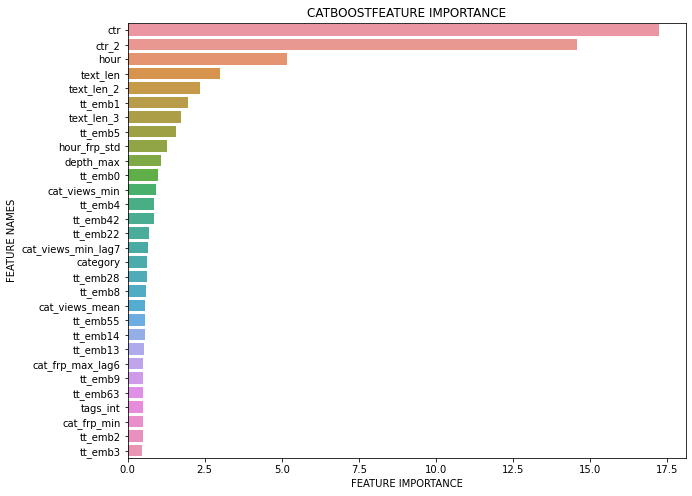

In [26]:
plot_feature_importance(model_views_end.get_feature_importance(), train_views_end.get_feature_names(), 'CATBOOST')

## depth

Обучаем модели для depth с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [27]:
cb_params_depth = cb_params_views

In [28]:
cb_params_depth['iterations'] = 1600

In [29]:
%%time
model_depth_start = get_model(train_depth_start, cb_params_depth)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1596        1596       0.47929     0.138784        0.97161      0.002873        0.036675       0.002137         0.008792        0.000178
1596
Learning rate set to 0.033607
0:	learn: 0.0516209	total: 93.2ms	remaining: 2m 28s
100:	learn: 0.0333598	total: 8.64s	remaining: 2m 7s
200:	learn: 0.0300182	total: 17.3s	remaining: 2m
300:	learn: 0.0269561	total: 25.6s	remaining: 1m 50s
400:	learn: 0.0242301	total: 34.2s	remaining: 1m 41s
500:	learn: 0.0221129	total: 42.9s	remaining: 1m 33s
600:	learn: 0.0203158	total: 51.4s	remaining: 1m 25s
700:	learn: 0.0186815	total: 59.9s	remaining: 1m 16s
800:	learn: 0.0170199	total: 1m 9s	remaining: 1m 8s
900:	learn: 0.0155511	total: 1m 17s	remaining: 59.7s
1000:	learn: 0.0142585	total: 1m 25s	remaining: 51.1s
1100:	learn: 0.0130981	total: 1m 34s	remaining: 42.5s
1200:	learn: 0.0120625	total: 1m 43s	remaining: 34s
1300:	le

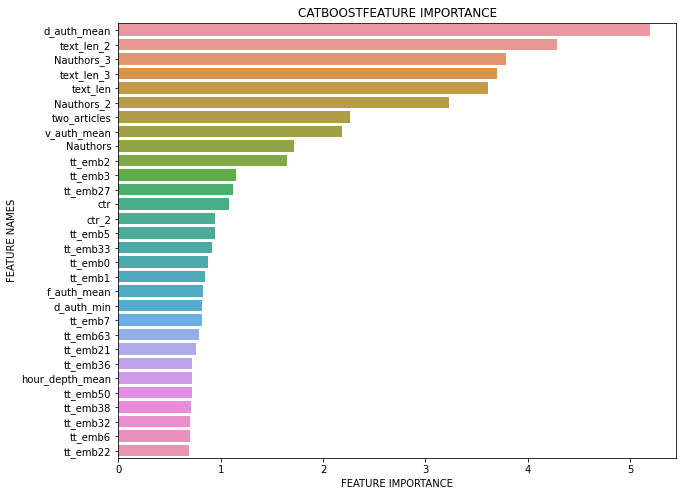

In [30]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_depth_start.get_feature_importance(), train_depth_start.get_feature_names(), 'CATBOOST')

In [31]:
cb_params_depth['iterations'] = 2500

In [32]:
%%time
model_depth_end = get_model(train_depth_end, cb_params_depth)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
2496        2496       0.28506     0.141042       0.979968      0.002423        0.017906        0.00419         0.003043        0.000134
2496
Learning rate set to 0.024706
0:	learn: 0.0215912	total: 84.4ms	remaining: 3m 30s
100:	learn: 0.0178168	total: 9.25s	remaining: 3m 39s
200:	learn: 0.0153661	total: 16.4s	remaining: 3m 6s
300:	learn: 0.0139178	total: 23.8s	remaining: 2m 53s
400:	learn: 0.0128439	total: 30.1s	remaining: 2m 37s
500:	learn: 0.0120001	total: 36.3s	remaining: 2m 24s
600:	learn: 0.0112430	total: 42.6s	remaining: 2m 14s
700:	learn: 0.0105696	total: 49.4s	remaining: 2m 6s
800:	learn: 0.0099710	total: 57.9s	remaining: 2m 2s
900:	learn: 0.0094273	total: 1m 6s	remaining: 1m 58s
1000:	learn: 0.0089423	total: 1m 15s	remaining: 1m 53s
1100:	learn: 0.0084590	total: 1m 24s	remaining: 1m 47s
1200:	learn: 0.0080035	total: 1m 33s	remaining: 1m 40s


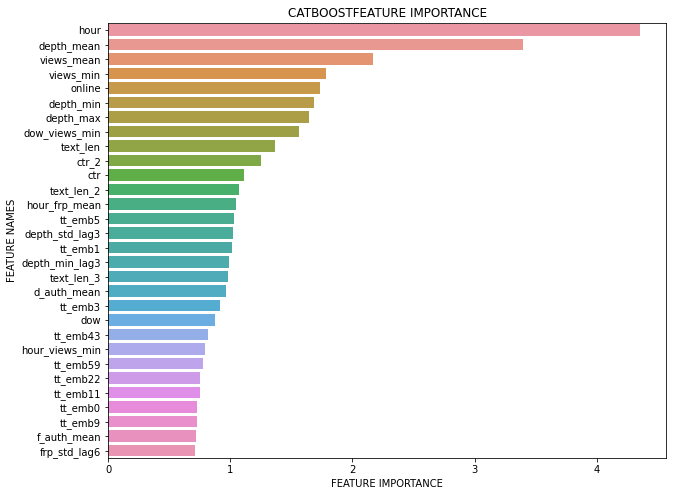

In [33]:
plot_feature_importance(model_depth_end.get_feature_importance(), train_depth_end.get_feature_names(), 'CATBOOST')

## full_reads_percent

Обучаем модели для full_reads_percent с разделением на модели start (данные до 2022-04-08) / end (данные после 2022-04-08) 

In [34]:
cb_params_frp = cb_params_views

In [35]:
cb_params_frp['iterations'] = 1400

In [36]:
%%time
model_frp_start = get_model(train_frp_start, cb_params_frp)

      iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
1247        1247      0.561634     0.004876        0.94645      0.001191         6.96986       0.123096         2.437519        0.032997
1247
Learning rate set to 0.040539
0:	learn: 10.3666595	total: 85.5ms	remaining: 1m 46s
100:	learn: 6.7587641	total: 9.03s	remaining: 1m 42s
200:	learn: 6.1228634	total: 14.9s	remaining: 1m 17s
300:	learn: 5.4357842	total: 20.7s	remaining: 1m 4s
400:	learn: 4.8145464	total: 26s	remaining: 54.8s
500:	learn: 4.2955233	total: 31.2s	remaining: 46.5s
600:	learn: 3.8468101	total: 36.5s	remaining: 39.2s
700:	learn: 3.4555002	total: 42.3s	remaining: 32.9s
800:	learn: 3.1410352	total: 48.2s	remaining: 26.8s
900:	learn: 2.8377759	total: 54s	remaining: 20.7s
1000:	learn: 2.5733919	total: 59.4s	remaining: 14.6s
1100:	learn: 2.3220825	total: 1m 4s	remaining: 8.6s
1200:	learn: 2.1093713	total: 1m 10s	remaining: 2.69s
1246:	learn: 

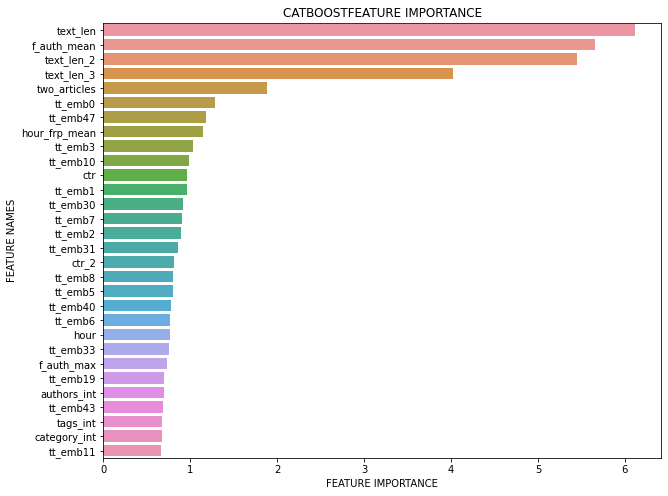

In [37]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_start.get_feature_importance(), train_frp_start.get_feature_names(), 'CATBOOST')

In [38]:
cb_params_frp['iterations'] = 1000

In [39]:
%%time
model_frp_end = get_model(train_frp_end, cb_params_frp)

     iterations  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  train-RMSE-std
992         992      0.546965     0.027092       0.884609      0.003785        6.500979       0.058168         3.284923        0.057523
992
Learning rate set to 0.049814
0:	learn: 9.4766064	total: 53.2ms	remaining: 52.7s
100:	learn: 6.2215611	total: 5.84s	remaining: 51.5s
200:	learn: 5.6143515	total: 11.1s	remaining: 43.8s
300:	learn: 4.9744536	total: 16.3s	remaining: 37.4s
400:	learn: 4.4734377	total: 21.5s	remaining: 31.7s
500:	learn: 4.0432355	total: 26.7s	remaining: 26.2s
600:	learn: 3.6408770	total: 31.9s	remaining: 20.8s
700:	learn: 3.2614508	total: 37.2s	remaining: 15.5s
800:	learn: 2.9596185	total: 42.9s	remaining: 10.2s
900:	learn: 2.6655347	total: 48.7s	remaining: 4.91s
991:	learn: 2.4350100	total: 54.3s	remaining: 0us
Wall time: 33min 35s


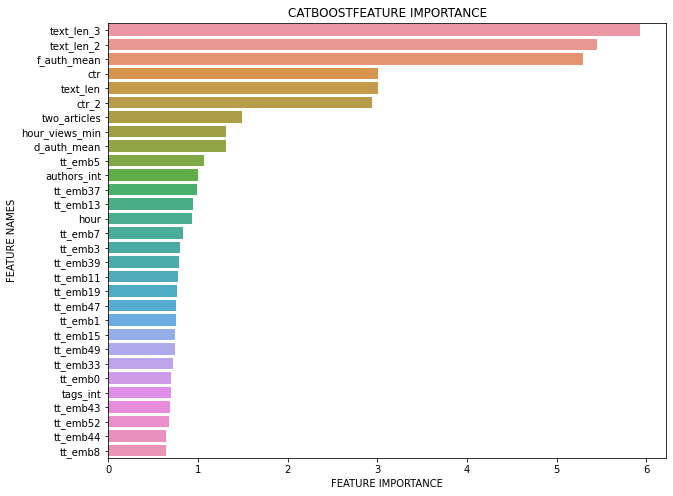

In [40]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(model_frp_end.get_feature_importance(), train_frp_end.get_feature_names(), 'CATBOOST')

## Сохраняем предсказания для ансамблей / стекинга

In [78]:
pred_train = pd.DataFrame()
pred_train[['document_id', 'distrib_brdr']] = df_train[['document_id', 'distrib_brdr']]
pred_train = pred_train.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [79]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.views.isna())

0

In [80]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.depth.isna())

0

In [81]:
pred_train.loc[pred_train.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_train[df_train.distrib_brdr == 1][cat_cols + num_cols])
pred_train.loc[pred_train.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_train[df_train.distrib_brdr == 0][cat_cols + num_cols])
sum(pred_train.full_reads_percent.isna())

0

## Сохраняем модели

In [82]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
model_views_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_views_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_v_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_depth_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_d_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_start.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_start.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )
model_frp_end.save_model(os.path.join(DIR_MODELS, f'{NAME}_f_end.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## Делаем предсказание / сабмит

In [83]:
subm = pd.DataFrame()
subm[['document_id', 'distrib_brdr']] = df_test[['document_id', 'distrib_brdr']]
subm = subm.reindex(['document_id', 'distrib_brdr', 'views', 'depth', 'full_reads_percent'], axis = 1)

In [84]:
subm.loc[subm.query('distrib_brdr == 1').index, 'views'] = model_views_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'views'] = model_views_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.views.isna())

0

In [85]:
subm.loc[subm.query('distrib_brdr == 1').index, 'depth'] = model_depth_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'depth'] = model_depth_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.depth.isna())

0

In [86]:
subm.loc[subm.query('distrib_brdr == 1').index, 'full_reads_percent'] = model_frp_start.predict(df_test[df_test.distrib_brdr == 1][cat_cols + num_cols])
subm.loc[subm.query('distrib_brdr == 0').index, 'full_reads_percent'] = model_frp_end.predict(df_test[df_test.distrib_brdr == 0][cat_cols + num_cols])
sum(subm.full_reads_percent.isna())

0

In [87]:
subm.drop(['distrib_brdr'], axis = 1, inplace = True)

In [88]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,209386.576303,1.177938,24.427403
1440,181331.352535,1.164771,25.032613
2645,188197.124290,1.187522,28.438711


In [89]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [90]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,17757.560986,1.215035,46.380446
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5752.302531,1.061197,35.176315
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,11560.447554,1.060698,31.109351
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,9168.779360,1.065092,38.096110
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,127568.917404,1.132620,28.052382


In [91]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [92]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Notebook Runtime: 336.00 Minutes
